# GLM-Infused SweetNet Experiments

Experimenting with a modified version of SweetNet that allows it to take pre-trained embeddings as input. To get there I need a way to take the embeddings I’ve gotten from roman and transform them into nice inputs for the model, and a way to set the initial features using these inputs. 


## Importing and exploring the GLM Embedding data

### Exploring embeddings

In [ ]:
# quick thing to load a pickle file

import pickle
import os # To check if file exists

pickle_file_path = 'glm_embeddings_1.pkl'

# --- Load the Pickle File ---
if os.path.exists(pickle_file_path):
    print(f"Loading embeddings from: {pickle_file_path}")
    try:
        # Open the file in binary read mode ('rb')
        with open(pickle_file_path, 'rb') as file_handle:
            # Load the object(s) from the pickle file
            loaded_embeddings = pickle.load(file_handle)

        print("Embeddings loaded successfully!")        

    except Exception as e:
        print(f"An error occurred while loading the pickle file: {e}")
else:
    print(f"Error: File not found at '{pickle_file_path}'. Please check the filename and path.")

Loading embeddings from: glm_embeddings_1.pkl
Embeddings loaded successfully!


In [ ]:
# lets do some quick exploration

# --- Explore the loaded data ---
print(f"Type of loaded object: {type(loaded_embeddings)}")

# Common formats for embeddings: dictionary or numpy array
if isinstance(loaded_embeddings, dict):
    print(f"Number of items (if dictionary): {len(loaded_embeddings)}")
    # print some keys to see what they look like
    print(f"Example keys (first 5): {list(loaded_embeddings.keys())[:5]}")
elif hasattr(loaded_embeddings, 'shape'):
    print(f"Shape (if array/tensor): {loaded_embeddings.shape}")
    if hasattr(loaded_embeddings, 'dtype'):
         print(f"Data type (if array/tensor): {loaded_embeddings.dtype}")

Type of loaded object: <class 'dict'>
Number of items (if dictionary): 2565
Example keys (first 5): ['!GlcNAc', '-10', '-12', '-2', '-4']


In [ ]:
print(list(loaded_embeddings.keys())[5:30]) # Print more keys

['-6', '-8', '0dHex', '1,4-Anhydro-Gal-ol', '1,5-Anhydro-D-AltNAc-ol', '1,5-Anhydro-D-FucN-ol', '1,5-Anhydro-D-Rha4NAc-ol', '1,5-Anhydro-Gal-ol', '1,5-Anhydro-GalNAc-ol', '1,5-Anhydro-Glc-ol', '1,5-Anhydro-Glc-onic', '1,5-Anhydro-GlcN2S-ol', '1,5-Anhydro-GlcN2S6S-ol', '1,5-Anhydro-GlcNAc-ol', '1,5-Anhydro-GlcNAc-onic', '1,5-Anhydro-Man-ol', '1,5-Anhydro-ManNAc-ol', '1,5-Anhydro-Xyl-ol', '1,5-Anhydro-Xyl2F-ol', '1-1', '1-2', '1-3', '1-4', '1-5', '1-6']


In [ ]:
example_key = '!GlcNAc' 
if example_key in loaded_embeddings:
    embedding_vector = loaded_embeddings[example_key]
    print(f"Type of value for '{example_key}': {type(embedding_vector)}")
    if hasattr(embedding_vector, 'shape'):
        print(f"Shape of value: {embedding_vector.shape}") # This gives dimensionality!
        print(f"Dtype of value: {embedding_vector.dtype}")
    print(embedding_vector) # Print the vector itself if it's not too long
else:
    print(f"Key '{example_key}' not found.")

Type of value for '-8': <class 'numpy.ndarray'>
Shape of value: (320,)
Dtype of value: float32
[ 9.33886290e-01 -7.57189512e-01 -5.22765040e-01  4.93726492e-01
  3.03156078e-01 -1.72754931e+00  2.03015614e+00 -1.13539708e+00
 -8.32044244e-01 -6.09763384e-01 -5.63947335e-02 -2.68140852e-01
 -6.37493312e-01  1.45667583e-01 -7.75620103e-01 -1.39048725e-01
  1.06042847e-01 -3.74972522e-01  7.91566074e-01 -1.03034627e+00
 -1.12639211e-01 -3.78986076e-03  5.92547238e-01  2.81559825e-01
 -5.21002829e-01  9.35327411e-01  2.56601274e-01 -3.91364455e-01
  2.72188634e-02  5.00928342e-01 -5.55309415e-01  1.28289807e+00
 -6.45282388e-01  5.19899249e-01  6.10100806e-01  1.84122849e+00
  3.11432898e-01 -7.64928609e-02 -1.05589128e+00  6.50653005e-01
  9.70111132e-01  7.40227938e-01  8.39829683e-01 -3.04328918e-01
 -1.06630003e+00  4.53770608e-01  4.27673876e-01 -6.02427721e-01
  4.39536482e-01 -1.16493046e+00 -2.04154789e-01  1.13036299e+00
  2.51586974e-01  1.04393315e+00  2.60879964e-01  4.63881493

In [ ]:
# let's look at the keys a bit more closely

import collections

key_types = collections.defaultdict(int)
for key in loaded_embeddings.keys():
    if '-' in key and not any(char.isalpha() for char in key):
        key_types['linkage_or_modification'] += 1
    elif key[0].isalpha():
        key_types['monosaccharide'] += 1
    else:
        key_types['other'] += 1

print(key_types)

defaultdict(<class 'int'>, {'other': 122, 'linkage_or_modification': 36, 'monosaccharide': 2407})


In [ ]:
# Let's explore those Other keys 

other_keys = []
for key in loaded_embeddings.keys():
    if '-' in key and not any(char.isalpha() for char in key):
        pass # linkage_or_modification
    elif key[0].isalpha():
        pass # monosaccharide
    else:
        other_keys.append(key)

print(f"Number of 'other' keys: {len(other_keys)}")
print(f"Examples of 'other' keys: {other_keys[:20]}") # Print the first 20

Number of 'other' keys: 122
Examples of 'other' keys: ['!GlcNAc', '0dHex', '1,4-Anhydro-Gal-ol', '1,5-Anhydro-D-AltNAc-ol', '1,5-Anhydro-D-FucN-ol', '1,5-Anhydro-D-Rha4NAc-ol', '1,5-Anhydro-Gal-ol', '1,5-Anhydro-GalNAc-ol', '1,5-Anhydro-Glc-ol', '1,5-Anhydro-Glc-onic', '1,5-Anhydro-GlcN2S-ol', '1,5-Anhydro-GlcN2S6S-ol', '1,5-Anhydro-GlcNAc-ol', '1,5-Anhydro-GlcNAc-onic', '1,5-Anhydro-Man-ol', '1,5-Anhydro-ManNAc-ol', '1,5-Anhydro-Xyl-ol', '1,5-Anhydro-Xyl2F-ol', '1b-4', '1dAlt-ol']


In [ ]:
# Let's look at 50 more keys

print(f"More Examples of 'other' keys: {other_keys[20:70]}")

More Examples of 'other' keys: ['1dEry-ol', '2,3-Anhydro-All', '2,3-Anhydro-Man', '2,3-Anhydro-Rib', '2,5-Anhydro-D-Alt-ol', '2,5-Anhydro-D-Alt3S-ol', '2,5-Anhydro-D-Tal', '2,5-Anhydro-Glc', '2,5-Anhydro-L-Man-ol', '2,5-Anhydro-Man', '2,5-Anhydro-Man-ol', '2,5-Anhydro-Man1S-ol', '2,5-Anhydro-Man3S-ol', '2,5-Anhydro-Man6S', '2,5-Anhydro-Tal-ol', '2,5-Anhydro-Tal6P', '2,6-Anhydro-Glc5NAc-ol', '2,6-Anhydro-L-Gul-ol', '2,6-Anhydro-L-Gul-onic', '2,6-Anhydro-Man-ol', '2,6-Anhydro-Tal5NAc-ol', '2,7-Anhydro-Kdo', '2,7-Anhydro-Kdof', '2dAraHexA', '3,6-Anhydro-Fruf', '3,6-Anhydro-Gal', '3,6-Anhydro-Gal2S', '3,6-Anhydro-Glc', '3,6-Anhydro-L-Gal', '3,6-Anhydro-L-Gal2Me', '3-Anhydro-Gal', '3-Anhydro-Gal2S', '3dFuc', '3dGal', '3dLyxHep-ulosaric', '4,7-Anhydro-Kdo', '4,7-Anhydro-KdoOPEtN', '4,8-Anhydro-Kdo', '4d8dNeu5Ac', '4dAraHex', '4dEry-ol', '4dFuc', '4dGal', '4dNeu5Ac', '4dThrHexNAcA4en', '4eLeg5Ac7Ac', '5dAraf', '5dAraf3Me', '5dLyxf3CFo', '5dLyxf3CMe']


In [ ]:
# Let's explore those monosaccharide keys
monosaccharide = []
for key in loaded_embeddings.keys():
    if '-' in key and not any(char.isalpha() for char in key):
        pass # linkage_or_modification
    elif key[0].isalpha():
        monosaccharide.append(key)
    else:
        pass # other

print(f"Number of 'monosaccharide' keys: {len(monosaccharide)}")
print(f"Examples of 'monosaccharide' keys: {monosaccharide[:50]}") # Print the first 50

Number of 'monosaccharide' keys: 2407
Examples of 'monosaccharide' keys: ['Abe', 'Abe1PP', 'Abe2Ac', 'AbeOAc', 'Acarbose', 'AcefA', 'Aci5Ac7Ac', 'AcoNAc', 'All', 'All-ol', 'All1S2S3S4S', 'All2Ac3Ac', 'All2S3S4S', 'All3Ac', 'All6Ac', 'AllN', 'AllN1P', 'AllNAc', 'AllNAc6Me', 'AllOMe', 'Alt', 'AltA', 'AltA2N', 'AltA2S', 'AltAN', 'AltNAc', 'AltNAcA', 'AltNAcA1Prop', 'Altf', 'AltfOAc', 'Amikacin', 'Api', 'ApiOAc', 'ApiOMe-ol', 'Apif', 'Ara', 'Ara-ol', 'Ara1Cer2Ac', 'Ara1Me', 'Ara1N4P', 'Ara1P4N', 'Ara1PP', 'Ara1PP2NAc', 'Ara1PP4N', 'Ara1PP4NFo', 'Ara2Ac', 'Ara2Ac3Ac', 'Ara2Ac3Ac4Ac', 'Ara2Ac4Ac', 'Ara2Ac5P-ol']


In [ ]:
# To be throughough, let's look at 50 Linkage or Modification keys as well
linkage_or_modification = []
for key in loaded_embeddings.keys():
    if '-' in key and not any(char.isalpha() for char in key):
        linkage_or_modification.append(key)
    elif key[0].isalpha():
        pass # monosaccharide
    else:
        pass # other

print(f"Number of 'linkage_or_modification' keys: {len(linkage_or_modification)}")
print(f"Examples of 'linkage_or_modification' keys: {linkage_or_modification[:50]}") # Print the first 50

Number of 'linkage_or_modification' keys: 36
Examples of 'linkage_or_modification' keys: ['-10', '-12', '-2', '-4', '-6', '-8', '1-1', '1-2', '1-3', '1-4', '1-5', '1-6', '1-?', '2-3', '2-4', '2-5', '2-6', '3-1', '3-5', '4-1', '4-5', '5-1', '5-2', '5-3', '5-4', '5-5', '5-6', '6-1', '6-3', '6-4', '?1-2', '?1-3', '?1-4', '?1-6', '?1-?', '?2-?']


In [96]:
# wait, a couple of weeks later and I couldn't figure out why my glm-infused model wasn't converging, 
# and I just realised that the embeddings were all the same, no wonder it didn't work. 
# I should have looked at the embeddings themselves, not just the keys.

import pickle

pickle_file_path = 'glm_embeddings_1.pkl'

with open(pickle_file_path, 'rb') as f:
    loaded_embeddings = pickle.load(f)

first_embedding = None
all_same = True
if loaded_embeddings:
    first_key = next(iter(loaded_embeddings))
    first_embedding = loaded_embeddings[first_key]
    for key, embedding in loaded_embeddings.items():
        if not (embedding == first_embedding).all():
            all_same = False
            print(f"Found a different embedding for key: {key}")
            break

if all_same and first_embedding is not None:
    print("All embeddings in the loaded dictionary appear to be the same.")
elif first_embedding is None:
    print("The embedding dictionary is empty.")
else:
    print("Embeddings in the dictionary are not all the same.")

print(f"Number of embeddings in the dictionary: {len(loaded_embeddings)}")
if first_embedding is not None:
    print(f"First embedding:")
    print(first_embedding)

All embeddings in the loaded dictionary appear to be the same.
Number of embeddings in the dictionary: 2565
First embedding:
[ 9.33886290e-01 -7.57189512e-01 -5.22765040e-01  4.93726492e-01
  3.03156078e-01 -1.72754931e+00  2.03015614e+00 -1.13539708e+00
 -8.32044244e-01 -6.09763384e-01 -5.63947335e-02 -2.68140852e-01
 -6.37493312e-01  1.45667583e-01 -7.75620103e-01 -1.39048725e-01
  1.06042847e-01 -3.74972522e-01  7.91566074e-01 -1.03034627e+00
 -1.12639211e-01 -3.78986076e-03  5.92547238e-01  2.81559825e-01
 -5.21002829e-01  9.35327411e-01  2.56601274e-01 -3.91364455e-01
  2.72188634e-02  5.00928342e-01 -5.55309415e-01  1.28289807e+00
 -6.45282388e-01  5.19899249e-01  6.10100806e-01  1.84122849e+00
  3.11432898e-01 -7.64928609e-02 -1.05589128e+00  6.50653005e-01
  9.70111132e-01  7.40227938e-01  8.39829683e-01 -3.04328918e-01
 -1.06630003e+00  4.53770608e-01  4.27673876e-01 -6.02427721e-01
  4.39536482e-01 -1.16493046e+00 -2.04154789e-01  1.13036299e+00
  2.51586974e-01  1.04393315e+

### Load the glycowork libr

I'll load the glycowork library and compare it to the keys in the embedding file

In [ ]:
from glycowork.glycan_data import loader

glycowork_vocabulary = loader.lib

print(f"Number of items in glycowork vocabulary: {len(glycowork_vocabulary)}")
print(f"Example keys from glycowork vocabulary (first 20): {list(glycowork_vocabulary.keys())[:20]}")

Number of items in glycowork vocabulary: 2565
Example keys from glycowork vocabulary (first 20): ['!GlcNAc', '-10', '-12', '-2', '-4', '-6', '-8', '0dHex', '1,4-Anhydro-Gal-ol', '1,5-Anhydro-D-AltNAc-ol', '1,5-Anhydro-D-FucN-ol', '1,5-Anhydro-D-Rha4NAc-ol', '1,5-Anhydro-Gal-ol', '1,5-Anhydro-GalNAc-ol', '1,5-Anhydro-Glc-ol', '1,5-Anhydro-Glc-onic', '1,5-Anhydro-GlcN2S-ol', '1,5-Anhydro-GlcN2S6S-ol', '1,5-Anhydro-GlcNAc-ol', '1,5-Anhydro-GlcNAc-onic']


Nice, they seem to correspond one to one!

That saves me a lot of work down the line (Thanks Roman)

In [ ]:
# let's look at one of the keys in the glycowork vocabulary to see what they return
example_glycowork_key = '-10'
if example_glycowork_key in glycowork_vocabulary:
    glycowork_value = glycowork_vocabulary[example_glycowork_key]
    print(f"Type of value for '{example_glycowork_key}': {type(glycowork_value)}")
    print(glycowork_value)   

Type of value for '-10': <class 'int'>
1


## Data Loading

### Load, filter, and transform glycowork data into glycan_loaders ||||run on kernel restart||||
This is used to load and filter glycowork data for a specific prediction task

In [1]:
# function to load the full sugarbase dataset and make a custom dataframe for the problem you want to tackle

from glycowork.glycan_data.loader import build_custom_df, df_glycan
from glycowork.ml.train_test_split import prepare_multilabel
from typing import List, Tuple
from collections import Counter

def build_multilabel_dataset(glycan_dataset: str = 'df_species',
                          glycan_class: str = 'Kingdom',
                          min_class_size: int = 6) -> Tuple[List[str], List[List[float]]]:
    """
    Loads glycan data, prepares it for multi-label classification,
    and removes classes with fewer than min_class_size samples.

    Args:
        glycan_dataset: The glycowork dataset to use. Options include: 
            'df_species', 'df_tissue', and 'df_disease'.            
        glycan_class: The class to predict. Options include:
            df_species: 'Species', 'Genus', 'Family', 'Order', 'Class', 'Phylum', 'Kingdom', 'Domain', 'ref'
            df_tissue:  'tissue_sample', 'tissue_species', 'tissue_id', 'tissue_ref'
            df_disease: 'disease_association', 'disease_sample', 'disease_direction', 'disease_species', 'disease_id', 'disease_ref'
        min_class_size: Minimum number of samples required for a class to be included. Set to 1 to include all classes.

    Returns:
        A tuple containing:
        - filtered_glycans: List of glycans after filtering rare classes.
        - filtered_labels: List of corresponding label vectors.
    """
    # Load data
    all_glycan_data = df_glycan

    # Build custom dataframe
    custom_glycan_df = build_custom_df(all_glycan_data, glycan_dataset)

    # Prepare for multi-label prediction
    glycans, labels = prepare_multilabel(custom_glycan_df, glycan_class)

    # if needed, removes classes with fewer than min_class_size samples.
    if(min_class_size > 1):

        # Convert labels to string representation for counting
        label_strings = [''.join(map(str, label)) for label in labels]

        # Count occurrences of each label combination
        label_counts = Counter(label_strings)

        # Filter glycans and labels based on class size
        filtered_glycans = [glycans[i] for i, label_str in enumerate(label_strings) if label_counts[label_str] >= min_class_size]
        filtered_labels = [labels[i] for i, label_str in enumerate(label_strings) if label_counts[label_str] >= min_class_size]
        print(f"Number of unique glycans left after filtering rare classes (size >= {min_class_size}): {len(filtered_glycans)}/{len(glycans)}")

    else:
        filtered_glycans = glycans
        filtered_labels = labels
        print(f"Number of unique glycans: {len(filtered_glycans)}")

    return filtered_glycans, filtered_labels

In [2]:
glycans, labels = build_multilabel_dataset(glycan_dataset='df_species', glycan_class='Kingdom', min_class_size=6)

Number of unique glycans left after filtering rare classes (size >= 6): 23355/23503


In [3]:
# quick inspection of the data

print(f"Number of unique glycans: {len(glycans)}")
print(f"Number of label vectors: {len(labels)}")
print(f"Shape of first label vector (number of members in class): {len(labels[0])}")
print(f"\nFirst 5 glycans:\n{glycans[:5]}")
print(f"\nFirst 5 label vectors:\n{labels[:5]}")

Number of unique glycans: 23355
Number of label vectors: 23355
Shape of first label vector (number of members in class): 21

First 5 glycans:
['[Galf(b1-6)Galf(b1-2)]Man(a1-6)[Gal(a1-6)Galf(b1-2)]Man(a1-6)[Gal(a1-6)Galf(b1-2)]Man(a1-6)Man', 'Fuc(a1-2)Gal(b1-?)GlcNAc(b1-6)[Fuc(a1-?)[Gal(b1-?)]GlcNAc(b1-3)]Gal(b1-3)[GlcNAc(b1-6)]GalNAc', 'Man(a1-3)Man(a1-6)[Man(a1-3)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-3)]GlcNAc', 'Galf(b1-2)[Man(a1-3)][Man(a1-6)]Man(a1-6)[Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc', '[GlcNAcA3NAc4Ac(b1-4)][GlcNAc(b1-6)]Gal(a1-6)Glc(b1-3)GalNAc(b1-3)Gal']

First 5 label vectors:
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [4]:
# Split data into training, validation, and testing sets using StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from typing import List, Union

def multilabel_split(glycans: List[str], # list of IUPAC-condensed glycans
                 labels: List[Union[float, int, str]], # list of prediction labels
                 train_size: float = 0.7, # size of train set, the rest is split into validation and test sets
                 random_state: int = 42 # random state for reproducibility
                )-> Tuple[List[str], List[str], List[str], List[List[float]], List[List[float]], List[List[float]]]:
    """
    Splits the data into training and testing sets using StratifiedShuffleSplit.
    
    Args:
        glycans: List of glycans.
        labels: List of label vectors.
        train_size: Proportion of the dataset to include in the validation and test split.
        random_state: Controls the randomness of the split.
    
    Returns:
        A tuple containing:
            - train_glycans: Training set of glycans.
            - val_glycans: Validation set of glycans.
            - test_glycans: Testing set of glycans.
            - train_labels: Training set of labels.
            - val_labels: Validation set of labels.
            - test_labels: Testing set of labels.
    """
    
    # Convert labels to a suitable format for stratification (string representation)
    label_strings = [''.join(map(str, label)) for label in labels]

    # Initial split for train vs. (val + test)
    sss = StratifiedShuffleSplit(n_splits = 1, test_size = 1 - train_size, random_state = random_state)
    train_index, temp_index = next(sss.split(glycans, label_strings))
    train_glycans = [glycans[i] for i in train_index]
    train_labels = [labels[i] for i in train_index]
    temp_glycans = [glycans[i] for i in temp_index]
    temp_labels = [labels[i] for i in temp_index]

    # Split the remaining (val + test) into validation and test sets
    sss_val_test = StratifiedShuffleSplit(n_splits = 1, test_size = 0.5, random_state = random_state)
    val_index, test_index = next(sss_val_test.split(temp_glycans, [''.join(map(str, label)) for label in temp_labels]))
    val_glycans = [temp_glycans[i] for i in val_index]
    val_labels = [temp_labels[i] for i in val_index]
    test_glycans = [temp_glycans[i] for i in test_index]
    test_labels = [temp_labels[i] for i in test_index]

    print("Split complete!")
    print(f"Train set size: {len(train_glycans)}")
    print(f"Validation set size: {len(val_glycans)}")
    print(f"Test set size: {len(test_glycans)}")
        
    return train_glycans, val_glycans, test_glycans, train_labels, val_labels, test_labels





In [5]:
# Lets use the split function
train_glycans, val_glycans, test_glycans, train_labels, val_labels, test_labels = multilabel_split(glycans, labels, train_size=0.7, random_state=42)

Split complete!
Train set size: 16348
Validation set size: 3503
Test set size: 3504


In [ ]:
# Transforms IUPAC into graphs and makes the data loaders for the training and validation sets
from glycowork.ml.processing import split_data_to_train

glycan_loaders = split_data_to_train(
    glycan_list_train = train_glycans,
    glycan_list_val = val_glycans,
    labels_train = train_labels,
    labels_val = val_labels,
    batch_size = 128,  # Started with 32 Adjust as needed
    drop_last = False,
    augment_prob = 0.0,  # Adjust if you want augmentation for training
    generalization_prob = 0.2  # Adjust if you want generalization for training
)

### GIFFLAR Data

#### Load GIFFLAR Data


In [ ]:
#Loads the GIFFLAR dataset for the Taxonomy Kingdom (takes a long time to run(~40m), just use the file it generated)

import sys
sys.path.append('../GIFFLAR') 

from gifflar.benchmarks import get_dataset
import pathlib

data_config_kingdom = {"name": "Taxonomy_Kingdom"}
root_dir = pathlib.Path("./data_gifflar")  # Choose a directory to save the data
root_dir.mkdir(exist_ok=True, parents=True)

kingdom_dataset_config = get_dataset(data_config_kingdom, root_dir)


In [ ]:
# Print the dataset configuration
print(kingdom_dataset_config)



{'name': 'Taxonomy_Kingdom', 'filepath': WindowsPath('data_gifflar/taxonomy_Kingdom.tsv')}


#### Load and transform GIFFLAR Data


In [105]:
# Lets load the dataset into a pandas dataframe
import pandas as pd

filepath = 'data_gifflar/taxonomy_Kingdom.tsv'
#filepath = kingdom_dataset_config['filepath'] #If you've loaded it recently, which you shouldn't

# Load the dataset into a pandas DataFrame
multilabel_kingdom_df = pd.read_csv(filepath, sep="\t")
# Display the first few rows of the DataFrame
print(multilabel_kingdom_df.head())
# Display the shape of the DataFrame
print(f"Shape of the DataFrame: {multilabel_kingdom_df.shape}")

                                               IUPAC  Amoebozoa  Animalia  \
0  3,6-Anhydro-L-Gal(a1-3)Gal(b1-4)3,6-Anhydro-L-...          0         0   
1  3,6-Anhydro-L-Gal(a1-3)Gal(b1-4)3,6-Anhydro-L-...          0         0   
2  3,6-Anhydro-L-Gal(a1-3)Gal(b1-4)3,6-Anhydro-L-...          0         0   
3  3,6-Anhydro-L-Gal(a1-3)Gal(b1-4)3,6-Anhydro-L-...          0         0   
4  3,6-Anhydro-L-Gal(a1-3)GalOMe(b1-4)3,6-Anhydro...          0         0   

   Bacteria  Bamfordvirae  Chromista  Euryarchaeota  Excavata  Fungi  \
0         1             0          0              0         0      0   
1         1             0          0              0         0      0   
2         1             0          0              0         0      0   
3         1             0          0              0         0      0   
4         1             0          0              0         0      0   

   Heunggongvirae  Metazoa  Orthornavirae  Pararnavirae  Plantae  Protista  \
0               0        0

That looks fine

Let's convert them into graphs

In [106]:
print(multilabel_kingdom_df.columns)

Index(['IUPAC', 'Amoebozoa', 'Animalia', 'Bacteria', 'Bamfordvirae',
       'Chromista', 'Euryarchaeota', 'Excavata', 'Fungi', 'Heunggongvirae',
       'Metazoa', 'Orthornavirae', 'Pararnavirae', 'Plantae', 'Protista',
       'Riboviria', 'split'],
      dtype='object')


In [107]:

# Let's try the prepare multilabel function from the train_test_split module

from glycowork.ml.train_test_split import prepare_multilabel

# Prepare the multilabel dataset using the melt function
# The melt function is used to transform the DataFrame from wide format to long format
kingdom_df_melted = multilabel_kingdom_df.melt(
    id_vars=['IUPAC', 'split'],
    value_vars=['Amoebozoa', 'Animalia', 'Bacteria', 'Bamfordvirae', 'Chromista', 'Euryarchaeota', 'Excavata', 'Fungi', 'Heunggongvirae', 'Metazoa', 'Orthornavirae', 'Pararnavirae', 'Plantae', 'Protista', 'Riboviria'],
    var_name='Kingdom',
    value_name='Association'
)

# Filter for associations where the glycan belongs to the kingdom (Association == 1)
kingdom_df_melted = kingdom_df_melted[kingdom_df_melted['Association'] == 1]

# Splitting the dataset using the 'split' column
train_melted_df = kingdom_df_melted[kingdom_df_melted['split'] == 'train'].drop(columns=['split'])
val_melted_df = kingdom_df_melted[kingdom_df_melted['split'] == 'val'].drop(columns=['split'])
test_melted_df = kingdom_df_melted[kingdom_df_melted['split'] == 'test'].drop(columns=['split'])

# Finally using the prepare_multilabel function to prepare the data for training
glycan_train, label_train = prepare_multilabel(train_melted_df, rank='Kingdom', glycan_col='IUPAC')
glycan_val, label_val = prepare_multilabel(val_melted_df, rank='Kingdom', glycan_col='IUPAC')
glycan_test, label_test = prepare_multilabel(test_melted_df, rank='Kingdom', glycan_col='IUPAC')



In [108]:
# Lets make them into graphs again, but hyper efficiently this time

from glycowork.ml.processing import split_data_to_train

multilabel_kingdom_loaders = split_data_to_train(
    glycan_list_train=glycan_train,
    glycan_list_val=glycan_val,
    labels_train=label_train,
    labels_val=label_val,
    batch_size=32,  # Adjust as needed
    drop_last=False,
    augment_prob=0.0,  # Adjust if you want augmentation for training
    generalization_prob=0.0  # Adjust if you want generalization for training
)


#### Validate data

In [58]:
# Let's validate the split

import pandas as pd
import numpy as np
filepath = 'data_gifflar/taxonomy_Kingdom.tsv'

# 1. Load the original DataFrame
multilabel_kingdom_df_original = pd.read_csv(filepath, sep="\t")
kingdom_cols = ['Amoebozoa', 'Animalia', 'Bacteria', 'Bamfordvirae', 'Chromista', 'Euryarchaeota', 'Excavata', 'Fungi', 'Heunggongvirae', 'Metazoa', 'Orthornavirae', 'Pararnavirae', 'Plantae', 'Protista', 'Riboviria']

# 2. Split the original DataFrame by 'split'
train_df = multilabel_kingdom_df_original[multilabel_kingdom_df_original['split'] == 'train']
val_df = multilabel_kingdom_df_original[multilabel_kingdom_df_original['split'] == 'val']
test_df = multilabel_kingdom_df_original[multilabel_kingdom_df_original['split'] == 'test']

# 3. Extract glycans and labels directly
glycan_train_list = train_df['IUPAC'].tolist()
label_train_list = [train_df[kingdom].values.tolist() for kingdom in kingdom_cols]
label_train_list = list(zip(*label_train_list)) # Transpose

glycan_val_list = val_df['IUPAC'].tolist()
label_val_list = [val_df[kingdom].values.tolist() for kingdom in kingdom_cols]
label_val_list = list(zip(*label_val_list)) # Transpose

glycan_test_list = test_df['IUPAC'].tolist()
label_test_list = [test_df[kingdom].values.tolist() for kingdom in kingdom_cols]
label_test_list = list(zip(*label_test_list)) # Transpose

print(f"Number of training glycans: {len(glycan_train_list)}")
print(f"Number of validation glycans: {len(glycan_val_list)}")
print(f"Number of test glycans: {len(glycan_test_list)}")
print(f"Shape of training labels: {len(label_train_list)} x {len(label_train_list[0]) if label_train_list else 0}")
print(f"Shape of validation labels: {len(label_val_list)} x {len(label_val_list[0]) if label_val_list else 0}")
print(f"Shape of test labels: {len(label_test_list)} x {len(label_test_list[0]) if label_test_list else 0}")

# Now re-run the checking function (modified for this new label extraction)
def check_example_direct(glycan_list, label_list, split_name, original_df, kingdom_cols):
    if glycan_list:
        example_index = 0
        example_glycan = glycan_list[example_index]
        example_labels_split = list(label_list[example_index])

        original_row = original_df[original_df['IUPAC'] == example_glycan].iloc[0]
        labels_original = np.array([original_row[col] for col in kingdom_cols], dtype=np.float32).tolist()

        print(f"--- Checking example from {split_name} set (Direct) ---")
        print(f"Glycan: {example_glycan}")
        print(f"Split in original data: {original_row['split']}")
        print(f"Labels in split data: {example_labels_split}")
        print(f"Labels in original data: {labels_original}")
        if labels_original == example_labels_split:
            print("Labels match!")
        else:
            print("Labels DO NOT match!")
    else:
        print(f"{split_name} set is empty.")

check_example_direct(glycan_train_list, label_train_list, 'train', multilabel_kingdom_df_original, kingdom_cols)
check_example_direct(glycan_val_list, label_val_list, 'val', multilabel_kingdom_df_original, kingdom_cols)
check_example_direct(glycan_test_list, label_test_list, 'test', multilabel_kingdom_df_original, kingdom_cols)

Number of training glycans: 11593
Number of validation glycans: 3213
Number of test glycans: 1646
Shape of training labels: 11593 x 15
Shape of validation labels: 3213 x 15
Shape of test labels: 1646 x 15
--- Checking example from train set (Direct) ---
Glycan: 3,6-Anhydro-L-Gal(a1-3)Gal(b1-4)3,6-Anhydro-L-Gal(a1-3)Gal
Split in original data: train
Labels in split data: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Labels in original data: [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Labels match!
--- Checking example from val set (Direct) ---
Glycan: 3,6-Anhydro-L-Gal(a1-3)Gal(b1-4)3,6-Anhydro-L-Gal(a1-3)GalOMe(b1-4)3,6-Anhydro-L-Gal(a1-3)Gal
Split in original data: val
Labels in split data: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Labels in original data: [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Labels match!
--- Checking example from test set (Direct) ---
Glycan: 3,6-Anhydro-L-Gal(a1-3)GalOMe(b1-4)3,6-Anhydro-L-G

In [ ]:
print(multilabel_kingdom_loader)

NameError: name 'multilabel_kingdom_loader' is not defined

Batch: DataBatch(edge_index=[2, 430], labels=[462], string_labels=[32], y=[480], num_nodes=462, x=[462, 320], batch=[462], ptr=[33])
Number of graphs in batch: 32

First graph data: Data(edge_index=[2, 8], labels=[9], string_labels=[9], y=[15], x=[9, 320], num_nodes=9)
Node features (x): tensor([[ 0.9339, -0.7572, -0.5228,  ...,  1.8300,  0.1645,  1.2676],
        [ 0.9339, -0.7572, -0.5228,  ...,  1.8300,  0.1645,  1.2676],
        [ 0.9339, -0.7572, -0.5228,  ...,  1.8300,  0.1645,  1.2676],
        ...,
        [ 0.9339, -0.7572, -0.5228,  ...,  1.8300,  0.1645,  1.2676],
        [ 0.9339, -0.7572, -0.5228,  ...,  1.8300,  0.1645,  1.2676],
        [ 0.9339, -0.7572, -0.5228,  ...,  1.8300,  0.1645,  1.2676]])
Edge indices (edge_index): tensor([[1, 2, 3, 4, 5, 6, 7, 8],
        [0, 1, 2, 3, 4, 5, 6, 7]])
Labels (y): tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
String labels: ['Rha', 'a1-3', 'Rha', 'a1-4', 'GalNAcA3Ac', 'a1-3', 'QuiNAc', 'b1-2', 'Rha']


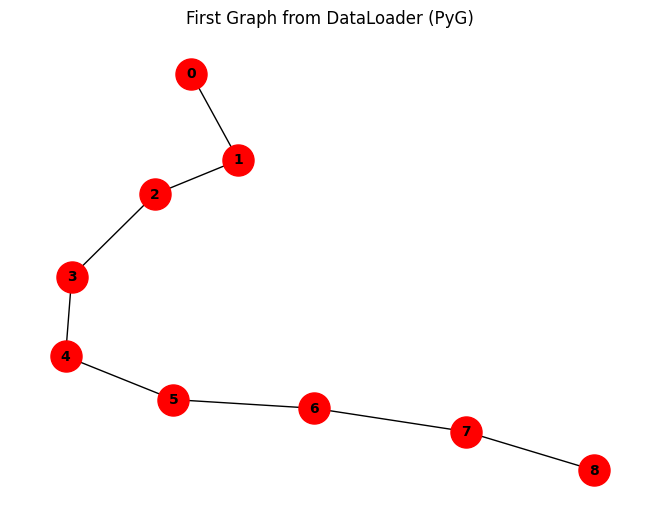

In [ ]:
# Check one of the graphs in the dataloader

import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

# Assuming your DataLoader is called 'multilabel_kingdom_loader'
inspected_loader = multilabel_kingdom_loaders_emb['train'] # Access the train DataLoader

# Get the first batch of data
try:
    batch = next(iter(inspected_loader))
    print("Batch:", batch)
    print("Number of graphs in batch:", batch.num_graphs)

    # Extract the first graph from the batch
    first_graph_data = batch[2] #change to check other graphs
    print("\nFirst graph data:", first_graph_data)
    print("Node features (x):", first_graph_data.x)
    print("Edge indices (edge_index):", first_graph_data.edge_index)
    print("Labels (y):", first_graph_data.y)
    print("String labels:", first_graph_data.string_labels)

    # Convert the PyG Data object to a NetworkX graph for visualization
    nx_graph = to_networkx(first_graph_data) 

    # Visualize the NetworkX graph
    nx_graph = to_networkx(first_graph_data)
    pos = nx.spring_layout(nx_graph)
    nx.draw(nx_graph, pos, with_labels=True, node_size=500, node_color="red", font_size=10, font_weight="bold", arrows=False)
    plt.title("First Graph from DataLoader (PyG)")
    plt.show()

except StopIteration:
    print("The DataLoader is empty.")
except Exception as e:
    print(f"An error occurred: {e}")

## Let's make a function to add embeddings to a dataloader object ||||run on kernel restart||||

In [7]:
# Let's load the embeddings again here, so I don't have to jump up and down whenever I reload the kernel)

import pickle
import os # To check if file exists

pickle_file_path = 'glm_embeddings_1.pkl'

# --- Load the Pickle File ---
if os.path.exists(pickle_file_path):
    print(f"Loading embeddings from: {pickle_file_path}")
    try:
        # Open the file in binary read mode ('rb')
        with open(pickle_file_path, 'rb') as file_handle:
            # Load the object(s) from the pickle file
            glm_embeddings = pickle.load(file_handle)

        print("Embeddings loaded successfully!")        

    except Exception as e:
        print(f"An error occurred while loading the pickle file: {e}")
else:
    print(f"Error: File not found at '{pickle_file_path}'. Please check the filename and path.")

Loading embeddings from: glm_embeddings_1.pkl
Embeddings loaded successfully!


In [8]:
# Function to add GLM embeddings to a dictionary of dataloaders before loading them into the model

import torch
from torch_geometric.loader import DataLoader

def add_glm_embeddings_to_dataloaders(dataloaders, glm_embeddings):
    embedded_loaders = {}
    embedding_dim = 320
    for split, loader in dataloaders.items():
        embedded_data_list = []
        for batch in loader:
            for graph in batch.to_data_list():
                node_embeddings = []
                if hasattr(graph, 'string_labels'):
                    for label in graph.string_labels:
                        if label in glm_embeddings:
                            embedding = glm_embeddings[label]
                            node_embeddings.append(torch.tensor(embedding))
                        else:
                            node_embeddings.append(torch.zeros(embedding_dim))
                    graph.x = torch.stack(node_embeddings).float()
                    #print(f"Shape of graph.x after adding embeddings: {graph.x.shape}")
                embedded_data_list.append(graph)

        embedded_loaders[split] = DataLoader(embedded_data_list, batch_size=32)
        print(f"GLM embeddings added to {split} DataLoader.")
    return embedded_loaders

In [9]:
# testing the function

multilabel_kingdom_loaders_emb = add_glm_embeddings_to_dataloaders(multilabel_kingdom_loaders, glm_embeddings)

NameError: name 'multilabel_kingdom_loaders' is not defined

## Lets look at the embeddings

In [92]:
# Looking at string labels

train_loader = multilabel_kingdom_loaders_emb['train'] 
batch = next(iter(train_loader))
first_graph_labels = batch[2].string_labels
print("Sample string_labels from the first graph:")
print(first_graph_labels[:20])  # Print the first 20 labels

Sample string_labels from the first graph:
['6dTal', 'a1-2', 'Rhaf', 'b1-5', 'Sug']


In [93]:
# looking at the embeddings themselves

train_loader = multilabel_kingdom_loaders_emb['train'] 
batch = next(iter(train_loader))
first_graph_embeddings = batch[2].x
print("Sample embeddings from the first graph:")
print(first_graph_embeddings[:20])  # Print the first 20 embeddings

Sample embeddings from the first graph:
tensor([[ 0.9339, -0.7572, -0.5228,  ...,  1.8300,  0.1645,  1.2676],
        [ 0.9339, -0.7572, -0.5228,  ...,  1.8300,  0.1645,  1.2676],
        [ 0.9339, -0.7572, -0.5228,  ...,  1.8300,  0.1645,  1.2676],
        [ 0.9339, -0.7572, -0.5228,  ...,  1.8300,  0.1645,  1.2676],
        [ 0.9339, -0.7572, -0.5228,  ...,  1.8300,  0.1645,  1.2676]])


In [32]:
print("\nSample keys from glm_embeddings:")
print(list(glm_embeddings.keys())[:200])  # Print the first 20 keys


Sample keys from glm_embeddings:
['!GlcNAc', '-10', '-12', '-2', '-4', '-6', '-8', '0dHex', '1,4-Anhydro-Gal-ol', '1,5-Anhydro-D-AltNAc-ol', '1,5-Anhydro-D-FucN-ol', '1,5-Anhydro-D-Rha4NAc-ol', '1,5-Anhydro-Gal-ol', '1,5-Anhydro-GalNAc-ol', '1,5-Anhydro-Glc-ol', '1,5-Anhydro-Glc-onic', '1,5-Anhydro-GlcN2S-ol', '1,5-Anhydro-GlcN2S6S-ol', '1,5-Anhydro-GlcNAc-ol', '1,5-Anhydro-GlcNAc-onic', '1,5-Anhydro-Man-ol', '1,5-Anhydro-ManNAc-ol', '1,5-Anhydro-Xyl-ol', '1,5-Anhydro-Xyl2F-ol', '1-1', '1-2', '1-3', '1-4', '1-5', '1-6', '1-?', '1b-4', '1dAlt-ol', '1dEry-ol', '2,3-Anhydro-All', '2,3-Anhydro-Man', '2,3-Anhydro-Rib', '2,5-Anhydro-D-Alt-ol', '2,5-Anhydro-D-Alt3S-ol', '2,5-Anhydro-D-Tal', '2,5-Anhydro-Glc', '2,5-Anhydro-L-Man-ol', '2,5-Anhydro-Man', '2,5-Anhydro-Man-ol', '2,5-Anhydro-Man1S-ol', '2,5-Anhydro-Man3S-ol', '2,5-Anhydro-Man6S', '2,5-Anhydro-Tal-ol', '2,5-Anhydro-Tal6P', '2,6-Anhydro-Glc5NAc-ol', '2,6-Anhydro-L-Gul-ol', '2,6-Anhydro-L-Gul-onic', '2,6-Anhydro-Man-ol', '2,6-Anhydro

## Copies of glycowork functions for experimentation ||||run on kernel restart||||

In [7]:
# SweetNet class

from typing import Dict, Optional, Tuple, Union, Literal

import numpy as np
try:
    import torch
    import torch.nn.functional as F
    from torch_geometric.nn import GraphConv
    from torch_geometric.nn import global_mean_pool as gap
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
except ImportError:
  raise ImportError("<torch or torch_geometric missing; did you do 'pip install glycowork[ml]'?>")
from glycowork.glycan_data.loader import lib, download_model 

class SweetNet(torch.nn.Module):
    def __init__(self, lib_size: int, # number of unique tokens for graph nodes
                 num_classes: int = 1, # number of output classes (>1 for multilabel)
                 hidden_dim: int = 320, # dimension of hidden layers (changed from 128 to 320)
                 use_external_embeddings: bool = False # whether to use external embeddings (GLM or other)
                ) -> None:
        "given glycan graphs as input, predicts properties via a graph neural network"
        #print("Using SweetNet from notebook cell!") # Check to see if I am running this in the notebook
        super(SweetNet, self).__init__()
        self.use_external_embeddings = use_external_embeddings
        # Convolution operations on the graph
        self.conv1 = GraphConv(hidden_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, hidden_dim)

        # Node embedding
        if use_external_embeddings:
            self.embedding_dim = hidden_dim
        else:
            self.item_embedding = torch.nn.Embedding(num_embeddings=lib_size+1, embedding_dim=hidden_dim)

 

        #self.item_embedding = torch.nn.Embedding(num_embeddings=lib_size+1, embedding_dim=hidden_dim)

        # Fully connected part
        self.lin1 = torch.nn.Linear(hidden_dim, 1024)
        self.lin2 = torch.nn.Linear(1024, 128)
        self.lin3 = torch.nn.Linear(128, num_classes)
        self.bn1 = torch.nn.BatchNorm1d(1024)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.act1 = torch.nn.LeakyReLU()
        self.act2 = torch.nn.LeakyReLU()

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, batch: torch.Tensor,
                inference: bool = False) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        
        # Getting node features
        if self.use_external_embeddings:
           # Use external embeddings (already in x)
            pass # x is already the embeddings
        else:
             # Use internal embedding
            x = self.item_embedding(x).squeeze(1)
            
        
        # Graph convolution operations (now using GLM embeddings as x)
        x = F.leaky_relu(self.conv1(x, edge_index))
        x = F.leaky_relu(self.conv2(x, edge_index))
        x = F.leaky_relu(self.conv3(x, edge_index))
        x = gap(x, batch)

        # Fully connected part
        x = self.act1(self.bn1(self.lin1(x)))
        x_out = self.bn2(self.lin2(x))
        x = F.dropout(self.act2(x_out), p = 0.5, training = self.training)

        x = self.lin3(x).squeeze(1)

        if inference:
          return x, x_out
        else:
          return x



### Other functions I might modify

In [8]:
# Train model function

import copy
import time
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
import numpy as np
import matplotlib.pyplot as plt
try:
    import torch
    # Choose the correct computing architecture
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
except ImportError:
    raise ImportError("<torch missing; did you do 'pip install glycowork[ml]'?>")
from sklearn.metrics import accuracy_score, matthews_corrcoef, mean_squared_error, \
    label_ranking_average_precision_score, ndcg_score, roc_auc_score, mean_absolute_error, r2_score
from glycowork.motif.annotate import annotate_dataset

class EarlyStopping:
    def __init__(self, patience: int = 7, # epochs to wait after last improvement
                 verbose: bool = False # whether to print messages
                ) -> None:
        "Early stops the training if validation loss doesn't improve after a given patience"
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = 0

    def __call__(self, val_loss: float, model: torch.nn.Module) -> None:
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss: float, model: torch.nn.Module) -> None:
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), 'drive/My Drive/checkpoint.pt')
        self.val_loss_min = val_loss


def sigmoid(x: float # input value
          ) -> float: # sigmoid transformed value
    "Apply sigmoid transformation to input"
    return 1 / (1 + np.exp(-x))


def disable_running_stats(model: torch.nn.Module # model to disable batch norm
                       ) -> None:
    "Disable batch normalization running statistics"

    def _disable(module):
        if isinstance(module, torch.nn.BatchNorm1d):
            module.backup_momentum = module.momentum
            module.momentum = 0

    model.apply(_disable)


def enable_running_stats(model: torch.nn.Module # model to enable batch norm
                      ) -> None:
    "Enable batch normalization running statistics"

    def _enable(module):
        if isinstance(module, torch.nn.BatchNorm1d) and hasattr(module, "backup_momentum"):
            module.momentum = module.backup_momentum

    model.apply(_enable)

################################################################################################################

def train_model(model: torch.nn.Module, # graph neural network for analyzing glycans
               dataloaders: Dict[str, torch.utils.data.DataLoader], # dict with 'train' and 'val' loaders
               criterion: torch.nn.Module, # PyTorch loss function
               optimizer: torch.optim.Optimizer, # PyTorch optimizer, has to be SAM if mode != "regression"
               scheduler: torch.optim.lr_scheduler._LRScheduler, # PyTorch learning rate decay
               num_epochs: int = 25, # number of epochs for training
               patience: int = 50, # epochs without improvement until early stop
               mode: str = 'classification', # 'classification', 'multilabel', or 'regression'
               mode2: str = 'multi', # 'multi' or 'binary' classification
               return_metrics: bool = False, # whether to return metrics
               use_external_embeddings: bool = False # whether to use external embeddings
              ) -> Union[torch.nn.Module, tuple[torch.nn.Module, dict[str, dict[str, list[float]]]]]: # best model from training and the training and validation metrics
    "trains a deep learning model on predicting glycan properties"

    since = time.time()
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")
    best_lead_metric = float("inf")

    if mode == 'classification':
         # Removed auroc from metrics to avoid calculation issues for now
        blank_metrics = {"loss": [], "acc": [], "mcc": []}
    elif mode == 'multilabel':
        blank_metrics = {"loss": [], "acc": [], "mcc": [], "lrap": [], "ndcg": []}
    else:
        blank_metrics = {"loss": [], "mse": [], "mae": [], "r2": []}

    metrics = {"train": copy.deepcopy(blank_metrics), "val": copy.deepcopy(blank_metrics)}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_metrics = copy.deepcopy(blank_metrics)
            running_metrics["weights"] = []

            for data in dataloaders[phase]:
                # Get all relevant node attributes
                print(f"Phase: {phase}, Data: {data}")
                print(f"Phase: {phase}, Data.x: {getattr(data, 'x', None)}") # Check if x exists and its value
                if use_external_embeddings:
                    x, y, edge_index, batch = data.x, data.y, data.edge_index, data.batch
                else:
                    x, y, edge_index, batch = data.labels, data.y, data.edge_index, data.batch
                prot = getattr(data, 'train_idx', None)
                if prot is not None:
                    prot = prot.view(max(batch) + 1, -1).to(device)
                x = x.to(device)
                if mode == 'multilabel':
                    y = y.view(max(batch) + 1, -1).to(device)
                else:
                    y = y.to(device)
                y = y.view(-1, 1) if mode == 'regression' else y
                edge_index = edge_index.to(device)
                batch = batch.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # First forward pass
                    if mode + mode2 == 'classificationmulti' or mode + mode2 == 'multilabelmulti':
                        enable_running_stats(model)
                    pred = model(prot, x, edge_index, batch) if prot is not None else model(x, edge_index, batch)
                    loss = criterion(pred, y)

                    if phase == 'train':
                        loss.backward()
                        if mode + mode2 == 'classificationmulti' or mode + mode2 == 'multilabelmulti':
                            optimizer.first_step(zero_grad = True)
                            # Second forward pass
                            disable_running_stats(model)
                            second_pred = model(prot, x, edge_index, batch) if prot is not None else model(x, edge_index, batch)
                            criterion(second_pred, y).backward()
                            optimizer.second_step(zero_grad = True)
                        else:
                            optimizer.step()
                
                # Check for single-class batches
                unique_classes = torch.unique(y).cpu().numpy()
                if len(unique_classes) == 1:
                    print(f"WARNING: Single-class batch detected in {phase} phase at epoch {epoch}!")
                    print(f"Batch labels: {unique_classes}")

                # Collecting relevant metrics
                running_metrics["loss"].append(loss.item())
                running_metrics["weights"].append(batch.max().cpu() + 1)

                y_det = y.detach().cpu().numpy()
                pred_det = pred.cpu().detach().numpy()
                if mode == 'classification':
                    if mode2 == 'multi':
                        pred_proba = np.exp(pred_det) / np.sum(np.exp(pred_det), axis = 1, keepdims = True)  # numpy softmax
                        pred2 = np.argmax(pred_det, axis = 1)
                    else:
                        pred_proba = sigmoid(pred_det)
                        pred2 = (pred_proba >= 0.5).astype(int)
                    running_metrics["acc"].append(accuracy_score(y_det.astype(int), pred2))
                    running_metrics["mcc"].append(matthews_corrcoef(y_det, pred2))
                    # commented out auroc because it was throwing errors
                    #running_metrics["auroc"].append(roc_auc_score(y_det.astype(int), pred_proba if mode2 == 'binary' else pred_proba[:, 1]))
                elif mode == 'multilabel':
                    pred_proba = sigmoid(pred_det)
                    pred2 = (pred_proba >= 0.5).astype(int)
                    running_metrics["acc"].append(accuracy_score(y_det.astype(int), pred2))
                    running_metrics["mcc"].append(matthews_corrcoef(y_det.flatten(), pred2.flatten()))
                    running_metrics["lrap"].append(label_ranking_average_precision_score(y_det.astype(int), pred_proba))
                    running_metrics["ndcg"].append(ndcg_score(y_det.astype(int), pred_proba))
                else:
                    running_metrics["mse"].append(mean_squared_error(y_det, pred_det))
                    running_metrics["mae"].append(mean_absolute_error(y_det, pred_det))
                    running_metrics["r2"].append(r2_score(y_det, pred_det))

            # Averaging metrics at end of epoch
            for key in running_metrics:
                if key == "weights":
                    continue
                metrics[phase][key].append(np.average(running_metrics[key], weights = running_metrics["weights"]))

            if mode == 'classification':
                print('{} Loss: {:.4f} Accuracy: {:.4f} MCC: {:.4f}'.format(phase, metrics[phase]["loss"][-1], metrics[phase]["acc"][-1], metrics[phase]["mcc"][-1]))
            elif mode == 'multilabel':
                print('{} Loss: {:.4f} LRAP: {:.4f} NDCG: {:.4f}'.format(phase, metrics[phase]["loss"][-1], metrics[phase]["acc"][-1], metrics[phase]["mcc"][-1]))
            else:
                print('{} Loss: {:.4f} MSE: {:.4f} MAE: {:.4f}'.format(phase, metrics[phase]["loss"][-1], metrics[phase]["mse"][-1], metrics[phase]["mae"][-1]))

            # Keep best model state_dict
            if phase == "val":
                if metrics[phase]["loss"][-1] <= best_loss:
                    best_loss = metrics[phase]["loss"][-1]
                    best_model_wts = copy.deepcopy(model.state_dict())

                    # Extract the lead metric (ACC, LRAP, or MSE) of the new best model
                    if mode == 'classification':
                        best_lead_metric = metrics[phase]["acc"][-1]
                    elif mode == 'multilabel':
                        best_lead_metric = metrics[phase]["lrap"][-1]
                    else:
                        best_lead_metric = metrics[phase]["mse"][-1]

                # Check Early Stopping & adjust learning rate if needed
                early_stopping(metrics[phase]["loss"][-1], model)
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(metrics[phase]["loss"][-1])
                else:
                    scheduler.step()

        if early_stopping.early_stop:
            print("Early stopping")
            break
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    if mode == 'classification':
        print('Best val loss: {:4f}, best Accuracy score: {:.4f}'.format(best_loss, best_lead_metric))
    elif mode == 'multilabel':
        print('Best val loss: {:4f}, best LRAP score: {:.4f}'.format(best_loss, best_lead_metric))
    else:
        print('Best val loss: {:4f}, best MSE score: {:.4f}'.format(best_loss, best_lead_metric))
    model.load_state_dict(best_model_wts)

    if return_metrics:
        return model, metrics

    # Plot loss & score over the course of training
    _, _ = plt.subplots(nrows=2, ncols=1)
    plt.subplot(2, 1, 1)
    plt.plot(range(epoch + 1), metrics["val"]["loss"])
    plt.title('Model Training')
    plt.ylabel('Validation Loss')
    plt.legend(['Validation Loss'], loc='best')

    plt.subplot(2, 1, 2)
    plt.xlabel('Number of Epochs')
    if mode == 'classification':
        plt.plot(range(epoch + 1), metrics["val"]["acc"])
        plt.ylabel('Validation Accuracy')
        plt.legend(['Validation Accuracy'], loc='best')
    elif mode == 'multilabel':
        plt.plot(range(epoch + 1), metrics["val"]["lrap"])
        plt.ylabel('Validation LRAP')
        plt.legend(['Validation LRAP'], loc='best')
    else:
        plt.plot(range(epoch + 1), metrics["val"]["mse"])
        plt.ylabel('Validation MSE')
        plt.legend(['Validation MSE'], loc='best')
    return model

In [9]:
# Init_weights function

def init_weights(model: torch.nn.Module, # neural network for analyzing glycans
                mode: str = 'sparse', # initialization algorithm: 'sparse', 'kaiming', 'xavier'
                sparsity: float = 0.1 # proportion of sparsity after initialization
               ) -> None:
    "initializes linear layers of PyTorch model with a weight initialization"
    #print("Using init_weights from notebook cell!") # Check to see if I am running this in the notebook
    if isinstance(model, torch.nn.Linear):
        if mode == 'sparse':
            torch.nn.init.sparse_(model.weight, sparsity = sparsity)
        elif mode == 'kaiming':
            torch.nn.init.kaiming_uniform_(model.weight)
        elif mode == 'xavier':
            torch.nn.init.xavier_uniform_(model.weight)
        else:
            print("This initialization option is not supported.")

In [10]:
# prep_model function

def prep_model(model_type: Literal["SweetNet", "LectinOracle", "LectinOracle_flex", "NSequonPred"], # type of model to create
              num_classes: int, # number of unique classes for classification
              libr: Optional[Dict[str, int]] = None, # dictionary of form glycoletter:index
              trained: bool = False, # whether to use pretrained model
              # set hidden_dim to 320 rather than 128 for the pretrained model
              # but 128 is the default for the model in the paper
              hidden_dim: int = 320, # hidden dimension for the model (SweetNet/LectinOracle only)
              use_external_embeddings: bool = False # whether to use external embeddings (GLM or other)
             ) -> torch.nn.Module: # initialized PyTorch model
    "wrapper to instantiate model, initialize it, and put it on the GPU"
    #print("Using prep_model from notebook cell!") # Check to see if I am running this in the notebook
    if libr is None:
      libr = lib
    if model_type == 'SweetNet':
      model = SweetNet(len(libr), num_classes = num_classes, hidden_dim = hidden_dim, use_external_embeddings = use_external_embeddings)
      model = model.apply(lambda module: init_weights(module, mode = 'sparse'))
      if trained:
        if hidden_dim != 128:
          raise ValueError("Hidden dimension must be 128 for pretrained model")
        model_path = download_model("glycowork_sweetnet_species.pt")
        model.load_state_dict(torch.load(model_path, map_location = device, weights_only = True))
      model = model.to(device)
    elif model_type == 'LectinOracle':
      model = LectinOracle(len(libr), num_classes = num_classes, input_size_prot = int(10*hidden_dim))
      model = model.apply(lambda module: init_weights(module, mode = 'xavier'))
      if trained:
        model_path = download_model("glycowork_lectinoracle.pt")
        model.load_state_dict(torch.load(model_path, map_location = device, weights_only = True))
      model = model.to(device)
    elif model_type == 'LectinOracle_flex':
      model = LectinOracle_flex(len(libr), num_classes = num_classes)
      model = model.apply(lambda module: init_weights(module, mode = 'xavier'))
      if trained:
        model_path = download_model("glycowork_lectinoracle_flex.pt")
        model.load_state_dict(torch.load(model_path, map_location = device, weights_only = True))
      model = model.to(device)
    elif model_type == 'NSequonPred':
      model = NSequonPred()
      model = model.apply(lambda module: init_weights(module, mode = 'xavier'))
      if trained:
        model_path = download_model("NSequonPred_batch32.pt")
        model.load_state_dict(torch.load(model_path, map_location = device, weights_only = True))
      model = model.to(device)
    else:
      print("Invalid Model Type")
    return model
    

## Testing using same framework as iteration 0 (basic kingdom sweetnet)

In [ ]:

# testing the modified SweetNet model on the GlycoWork dataset 
from glycowork.glycan_data.loader import df_species
from glycowork.ml.train_test_split import hierarchy_filter
from glycowork.ml.processing import split_data_to_train
from glycowork.ml import model_training

# silence the avalanche of "undefined" warnings
#import warnings
#from sklearn.exceptions import UndefinedMetricWarning
#warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

train_x, val_x, train_y, val_y, id_val, class_list, class_converter = hierarchy_filter(df_species,
                                                                                       rank = 'Kingdom')

dataloaders = split_data_to_train(train_x, val_x, train_y, val_y)




In [ ]:
# Lets split out the training code so I don't have to load the data each time

model = prep_model('SweetNet', len(class_list))
optimizer_ft, scheduler, criterion = model_training.training_setup(model, 0.0005, num_classes = len(class_list))
model_ft = model_training.train_model(model, dataloaders, criterion, optimizer_ft, scheduler,
                   num_epochs = 100, mode = 'classification',)

### Extra stuff

In [ ]:
# Let's look at the distribution of the Kingdoms in the original data

import pandas as pd

kingdom_counts = df_species['Kingdom'].value_counts()
print("Kingdom distribution in the original data:")
print(kingdom_counts)

In [ ]:
import pandas as pd

# Print the first few rows to get an overview
print(df_species.head())

# Print the data types of the columns
print(df_species.info())

# Check for duplicated glycans
print(f"Number of unique glycans: {df_species['glycan'].nunique()}")
print(f"Total number of rows: {len(df_species)}")

# If you suspect a column contains multiple kingdoms:
if 'Kingdom' in df_species.columns:  # Replace 'Kingdom' with the actual column name
    # Check the first few values of that column
    print(df_species['Kingdom'].head())
    # If it's a string with delimiters, count the delimiters
    if isinstance(df_species['Kingdom'][0], str) and ',' in df_species['Kingdom'][0]: #assuming ',' is the delimiter
        print(f"Example value: {df_species['Kingdom'][0]}")
        print(f"Number of commas in the first value: {df_species['Kingdom'][0].count(',')}")

    # Check for multiple columns representing kingdoms
    for col in df_species.columns:
        if col in ['Animalia', 'Bacteria', 'Plantae']:  # Add all possible kingdom column names
            print(f"Column '{col}': Data type = {df_species[col].dtype}, Unique values = {df_species[col].unique()}")

In [ ]:
seen = set()
duplicates_count = 0

for item in train_x:
    if item in seen:
        duplicates_count += 1
    else:
        seen.add(item)

print(f"Number of duplicates: {duplicates_count}")
print(f"Number of unique items: {len(seen)}")

## Time to train a multi-class multi-label Sweetnet on our properly loaded data 

Epoch 0/99
----------
train Loss: 1.9418 LRAP: 0.1018 NDCG: 0.5364
val Loss: 1.3059 LRAP: 0.4947 NDCG: 0.6652
Validation loss decreased (0.000000 --> 1.305928).  Saving model ...

Epoch 1/99
----------
train Loss: 1.2915 LRAP: 0.4963 NDCG: 0.6864
val Loss: 1.1568 LRAP: 0.6066 NDCG: 0.7330
Validation loss decreased (1.305928 --> 1.156826).  Saving model ...

Epoch 2/99
----------
train Loss: 1.1996 LRAP: 0.5826 NDCG: 0.7301
val Loss: 1.1165 LRAP: 0.6395 NDCG: 0.7663
Validation loss decreased (1.156826 --> 1.116533).  Saving model ...

Epoch 3/99
----------
train Loss: 1.1480 LRAP: 0.6077 NDCG: 0.7524
val Loss: 1.0790 LRAP: 0.6740 NDCG: 0.7806
Validation loss decreased (1.116533 --> 1.078970).  Saving model ...

Epoch 4/99
----------
train Loss: 1.1096 LRAP: 0.6380 NDCG: 0.7662
val Loss: 1.0661 LRAP: 0.6886 NDCG: 0.7969
Validation loss decreased (1.078970 --> 1.066058).  Saving model ...

Epoch 5/99
----------
train Loss: 1.0867 LRAP: 0.6491 NDCG: 0.7792
val Loss: 1.0446 LRAP: 0.7051 NDC

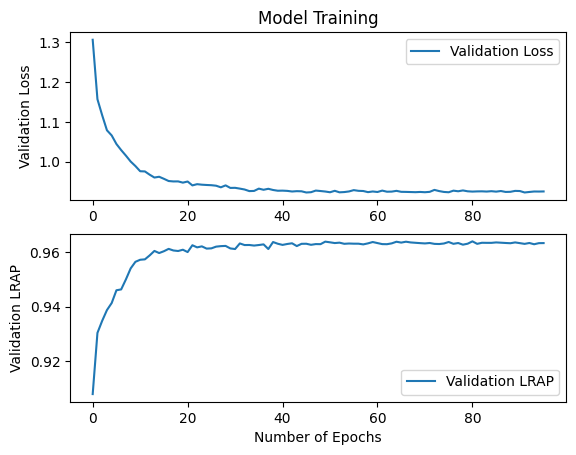

In [11]:


from glycowork.ml import model_training
classes = len(labels[0]) # number of classes in the dataset
dataloaders = glycan_loaders
model = prep_model('SweetNet', classes) 
optimizer_ft, scheduler, criterion = model_training.training_setup(model, 0.0005, num_classes = classes)
model_ft = model_training.train_model(model, dataloaders, criterion, optimizer_ft, scheduler,
                   num_epochs = 100, mode = 'multilabel',)

In [ ]:
# Lets Try with my new glm-infused data

classes = 15 # 15 kingdoms in the dataset, should read that from the data instead
dataloaders = multilabel_kingdom_loaders_emb
model = prep_model('SweetNet', classes, use_external_embeddings = True) 
optimizer_ft, scheduler, criterion = model_training.training_setup(model, 0.0005, num_classes = classes) #changed to 0.01 from 0.005 from 0.0005
model_ft = train_model(model, dataloaders, criterion, optimizer_ft, scheduler,
                   num_epochs = 1, mode = 'multilabel', use_external_embeddings = True)
